In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd


def format_variant_label(variant):
    """
    Format variant names to show:
    - Reanimation if applicable
    - Dictionary Size
    """
    parts = variant.split('_')
    is_reanim = parts[0].lower() == "reanim"
    dict_size = parts[-1] if parts[-1].isdigit() else "?"
    
    label_parts = []
    if is_reanim:
        label_parts.append("Reanimation")
    label_parts.append(f"Dictionary Size: {dict_size}")
    
    return " | ".join(label_parts)


def plot_digit_recovery_multiseed(
    seed_configs,
    out_dir="figures",
    save=True,
    formats=("pdf", "png"),
    sae_type=None
):
    """
    Load SAE results from multiple seeds, compute digit recovery stats,
    and plot the effect of penalty or ratio on unique digit recovery with
    a secondary y-axis for loss.
    """

    all_data = []

    # -------------------- Load data --------------------
    for seed_config in seed_configs:
        pkl_path = seed_config['pkl_path']
        log_path = seed_config.get('log_path', None)
        additional_log_paths = seed_config.get('additional_log_paths', None)
        seed_name = seed_config.get('seed_name', f'seed_{len(all_data) + 1}')

        with open(pkl_path, "rb") as f:
            all_results = pickle.load(f)

        training_logs = {}
        if log_path:
            training_logs.update(torch.load(log_path))
        if additional_log_paths:
            for add_log_path in additional_log_paths:
                training_logs.update(torch.load(add_log_path))

        for sae_name, results in all_results.items():
            if "auc_matrix" not in results or "per_neuron_df" not in results:
                continue

            sae_name_clean = sae_name.replace("_best_loss", "")
            try:
                penalty = float(sae_name_clean.split("_")[-1])
                variant = "_".join(sae_name_clean.split("_")[:-1])
            except ValueError:
                continue

            auc_matrix = results["auc_matrix"]
            neuron_df = results["per_neuron_df"]

            count_per_neuron = (auc_matrix > 0.95).sum(axis=1)
            pure_neurons = count_per_neuron[count_per_neuron == 1].index
            digits_represented = neuron_df.loc[pure_neurons, "best_digit"]
            num_digits = digits_represented.nunique()

            final_loss = None
            if training_logs and sae_name_clean in training_logs:
                final_loss = training_logs[sae_name_clean]['avg_loss'][-1]

            all_data.append({
                'seed': seed_name,
                'variant': variant,
                'penalty': penalty,
                'num_digits': num_digits,
                'final_loss': final_loss
            })

    df = pd.DataFrame(all_data)

    # -------------------- Map x-axis --------------------
    if sae_type == 'topk':
        df['dictionary_size'] = df.variant.apply(lambda x: float(x.split('_')[-1]))
        df['x_axis'] = 1 - (df['penalty'] / df['dictionary_size'])
        x_label = "Topk Ratio"
    else:
        l1_pen = [round(val, 6) for val in np.logspace(-5, 1, num=30)]
        df['penalty'] = df['penalty'].apply(lambda x: l1_pen[int(x)])
        df['x_axis'] = df['penalty']
        x_label = "L1 Penalty"

    # -------------------- Compute stats --------------------
    group_cols = ['variant', 'x_axis']
    digit_stats = df.groupby(group_cols)['num_digits'].agg(['mean', 'std']).reset_index()
    digit_stats['std'] = digit_stats['std'].fillna(0)

    loss_stats = df[df['final_loss'].notna()].groupby(group_cols)['final_loss'].agg(['mean', 'std']).reset_index()
    loss_stats['std'] = loss_stats['std'].fillna(0)

    # -------------------- Focus range filtering --------------------
    if sae_type == 'topk':
        digit_stats = digit_stats[(digit_stats['x_axis'] >= 0.7) & (digit_stats['x_axis'] <= 1.0)]
        loss_stats = loss_stats[(loss_stats['x_axis'] >= 0.7) & (loss_stats['x_axis'] <= 1.0)]
    else:
        digit_stats = digit_stats[(digit_stats['x_axis'] >= 1e-4) & (digit_stats['x_axis'] <= 1e-1)]
        loss_stats = loss_stats[(loss_stats['x_axis'] >= 1e-4) & (loss_stats['x_axis'] <= 1e-1)]

    # -------------------- Prepare plot --------------------
    if save:
        os.makedirs(out_dir, exist_ok=True)

    variants = digit_stats['variant'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(variants)))

    fig, ax1 = plt.subplots(figsize=(10, 6))
    lines, labels = [], []

    # Left y-axis: number of digits
    for idx, variant in enumerate(variants):
        variant_data = digit_stats[digit_stats['variant'] == variant].sort_values('x_axis')
        pretty_label = format_variant_label(variant)

        line = ax1.errorbar(
            variant_data['x_axis'],
            variant_data['mean'],
            yerr=variant_data['std'],
            marker="o",
            linewidth=2,
            capsize=5,
            label=pretty_label,
            color=colors[idx]
        )
        lines.append(line)
        labels.append(pretty_label)

    ax1.set_xlabel(x_label, fontsize=12)
    ax1.set_ylabel("Unique Classes Recovered", fontsize=12, color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True, linestyle="--", alpha=0.5)

    if sae_type != 'topk':
        ax1.set_xscale('log')

    # Right y-axis: final loss
    if not loss_stats.empty:
        ax2 = ax1.twinx()
        for idx, variant in enumerate(variants):
            variant_loss_data = loss_stats[loss_stats['variant'] == variant].sort_values('x_axis')
            if not variant_loss_data.empty:
                pretty_label = format_variant_label(variant)
                line = ax2.errorbar(
                    variant_loss_data['x_axis'],
                    variant_loss_data['mean'],
                    yerr=variant_loss_data['std'],
                    marker="s",
                    linestyle="--",
                    linewidth=1.5,
                    alpha=0.6,
                    capsize=4,
                    label=pretty_label,
                    color=colors[idx]
                )
                lines.append(line)
                labels.append(pretty_label)

        ax2.set_ylabel("Final Training Loss", fontsize=12, color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')

        if sae_type != 'topk':
            ax2.set_xscale('log')

    # -------------------- Legend and layout --------------------
    ax1.legend(
        lines,
        labels,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.12),
        ncol=2,
        frameon=True,
        fontsize=10,
        columnspacing=1.4,
        handlelength=2.0
    )

    fig.tight_layout(rect=[0, 0.05, 1, 1])
    fig.subplots_adjust(bottom=0.15)
    if not loss_stats.empty:
        fig.align_ylabels([ax1, ax2])
    plt.subplots_adjust(right=0.88)

    # -------------------- Save --------------------
    if save:
        for fmt in formats:
            out_file = os.path.join(out_dir, f"multiseed_dual_axis.{fmt}")
            plt.savefig(out_file, format=fmt, bbox_inches="tight")
            print(f"Saved plot to {out_file}")

    plt.show()

    return df, digit_stats, loss_stats

IndentationError: expected an indented block after 'for' statement on line 130 (4169786160.py, line 133)

/tmp/ipykernel_297395/1808431388.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_logs.update(torch.load(add_log_path))


Saved plot to CifarVanilla/multiseed_dual_axis.pdf
Saved plot to CifarVanilla/multiseed_dual_axis.png


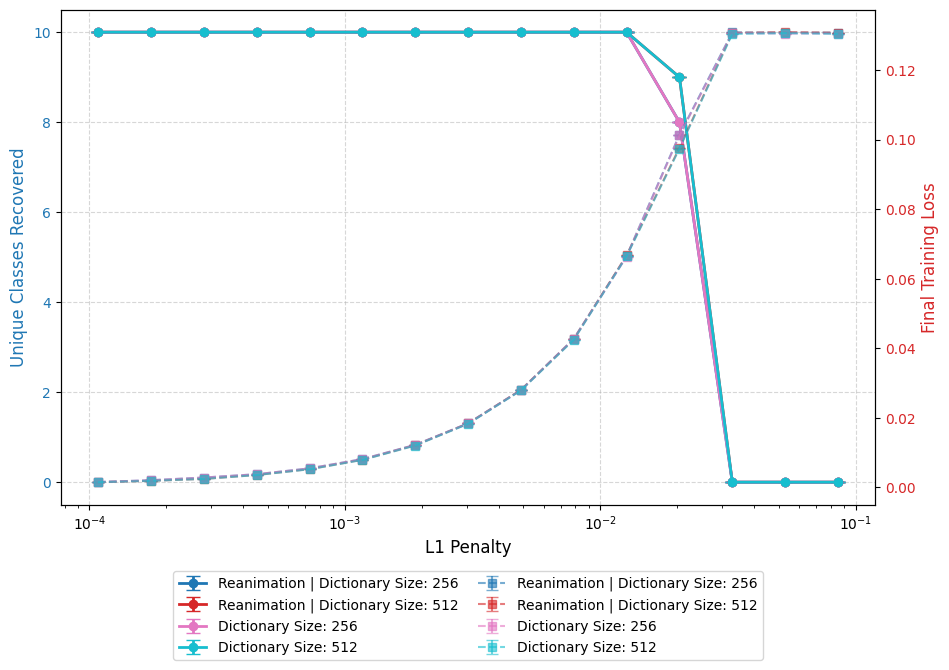

In [231]:
seed_configs = [
        {
            'seed_name': 'seed1',
            'pkl_path': '../logs/cifar10expt5/Seed1/vanilla_sae/regression_results.pkl',
            'additional_log_paths': [
                "../logs/cifar10expt5/Seed1/vanilla_sae/vanilla_sae_results_reanim.pt",
                "../logs/cifar10expt5/Seed1/vanilla_sae/vanilla_sae_results.pt"
            ]
        },
        {
            'seed_name': 'seed2',
            'pkl_path': '../logs/cifar10expt5/Seed2/vanilla_sae/regression_results.pkl',
            'additional_log_paths': [
                "../logs/cifar10expt5/Seed2/vanilla_sae/vanilla_sae_results_reanim.pt",
                "../logs/cifar10expt5/Seed2/vanilla_sae/vanilla_sae_results.pt"
            ]
        },
        {
            'seed_name': 'seed3',
            'pkl_path': '../logs/cifar10expt5/Seed3/vanilla_sae/regression_results.pkl',
            'additional_log_paths': [
                "../logs/cifar10expt5/Seed3/vanilla_sae/vanilla_sae_results_reanim.pt",
                "../logs/cifar10expt5/Seed3/vanilla_sae/vanilla_sae_results.pt"
            ]
        }
    ]
    
df, digit_stats, loss_stats = plot_digit_recovery_multiseed(
    seed_configs=seed_configs,
    out_dir="CifarVanilla",
    save=True,
    formats=["pdf", "png"]
)

/tmp/ipykernel_297395/1808431388.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_logs.update(torch.load(add_log_path))
/tmp/ipykernel_297395/1808431388.py:57: 

Saved plot to CifarTopk/multiseed_dual_axis.pdf
Saved plot to CifarTopk/multiseed_dual_axis.png


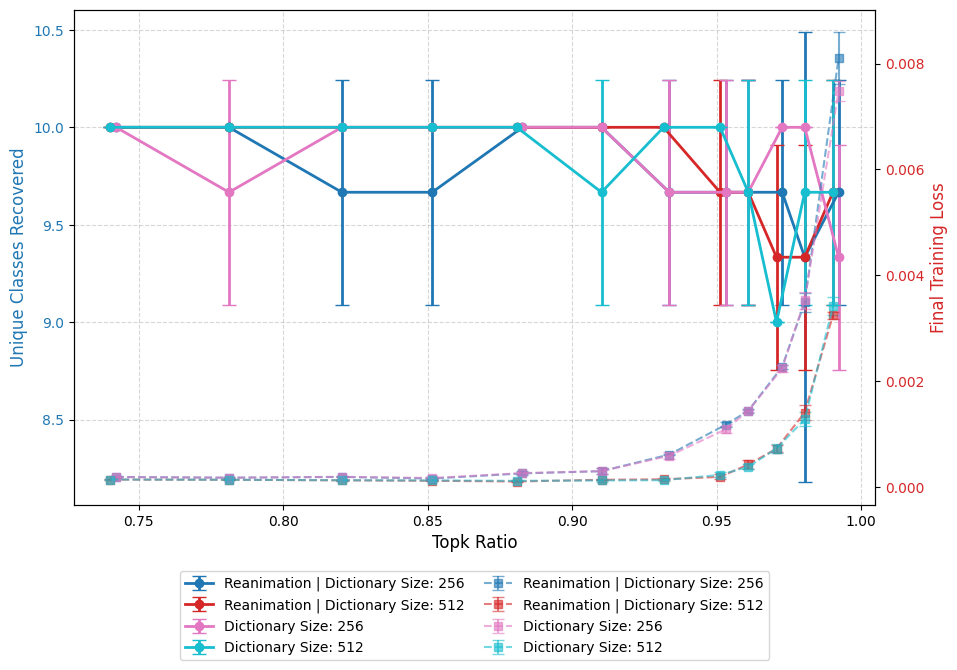

In [224]:
seed_configs = [
        {
            'seed_name': 'seed1',
            'pkl_path': '../logs/cifar10expt5/Seed1/topk_sae/regression_results.pkl',
            'additional_log_paths': [
                "../logs/cifar10expt5/Seed1/topk_sae/top_k_sae_results_reanim.pt",
                "../logs/cifar10expt5/Seed1/topk_sae/top_k_sae_results.pt"
            ]
        },
        {
            'seed_name': 'seed2',
            'pkl_path': '../logs/cifar10expt5/Seed2/topk_sae/regression_results.pkl',
            'additional_log_paths': [
                "../logs/cifar10expt5/Seed2/topk_sae/top_k_sae_results_reanim.pt",
                "../logs/cifar10expt5/Seed2/topk_sae/top_k_sae_results.pt"
            ]
        },
        {
            'seed_name': 'seed3',
            'pkl_path': '../logs/cifar10expt5/Seed3/topk_sae/regression_results.pkl',
            'additional_log_paths': [
                "../logs/cifar10expt5/Seed3/topk_sae/top_k_sae_results_reanim.pt",
                "../logs/cifar10expt5/Seed3/topk_sae/top_k_sae_results.pt"
            ]
        }
    ]
    
df, digit_stats, loss_stats = plot_digit_recovery_multiseed(
    seed_configs=seed_configs,
    out_dir="CifarTopk",
    save=True,
    formats=["pdf", "png"], 
    sae_type='topk'
)

/tmp/ipykernel_297395/1808431388.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_logs.update(torch.load(add_log_path))
/tmp/ipykernel_297395/1808431388.py:57: 

Saved plot to MnistVanilla/multiseed_dual_axis.pdf
Saved plot to MnistVanilla/multiseed_dual_axis.png


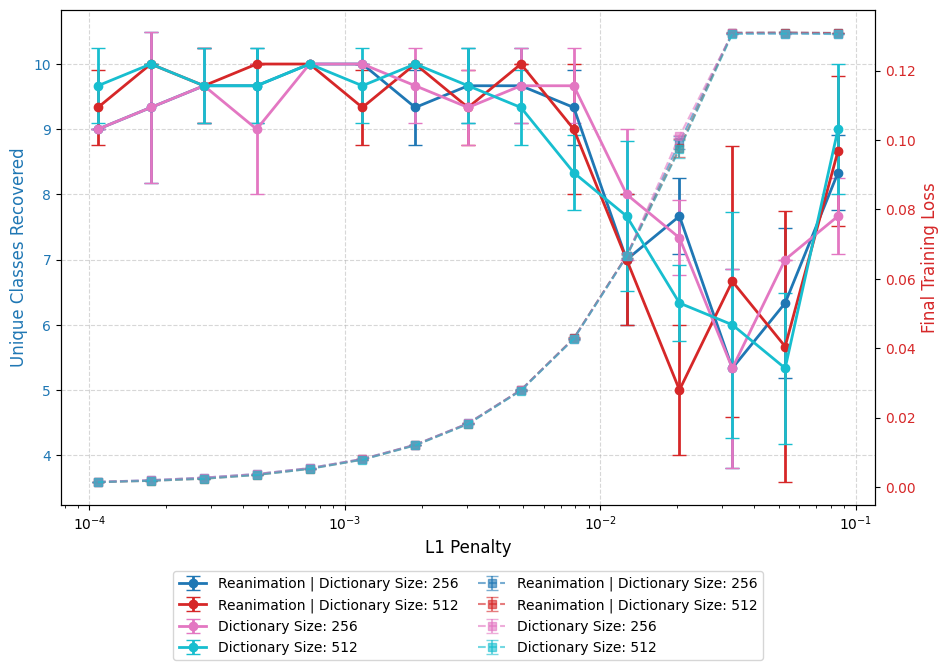

In [225]:
seed_configs = [
        {
            'seed_name': 'seed1',
            'pkl_path': '../logs/mnist_activation/Seed1/vanilla_sae/regression_results.pkl',
            'additional_log_paths': [
                "../logs/cifar10expt5/Seed1/vanilla_sae/vanilla_sae_results_reanim.pt",
                "../logs/cifar10expt5/Seed1/vanilla_sae/vanilla_sae_results.pt"
            ]
        },
        {
            'seed_name': 'seed2',
            'pkl_path': '../logs/mnist_activation/Seed2/vanilla_sae/regression_results.pkl',
            'additional_log_paths': [
                "../logs/cifar10expt5/Seed2/vanilla_sae/vanilla_sae_results_reanim.pt",
                "../logs/cifar10expt5/Seed2/vanilla_sae/vanilla_sae_results.pt"
            ]
        },
        {
            'seed_name': 'seed3',
            'pkl_path': '../logs/mnist_activation/Seed3/vanilla_sae/regression_results.pkl',
            'additional_log_paths': [
                "../logs/cifar10expt5/Seed3/vanilla_sae/vanilla_sae_results_reanim.pt",
                "../logs/cifar10expt5/Seed3/vanilla_sae/vanilla_sae_results.pt"
            ]
        }
    ]
    
df, digit_stats, loss_stats = plot_digit_recovery_multiseed(
    seed_configs=seed_configs,
    out_dir="MnistVanilla",
    save=True,
    formats=["pdf", "png"]
)

/tmp/ipykernel_297395/1808431388.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_logs.update(torch.load(add_log_path))
/tmp/ipykernel_297395/1808431388.py:57: 

Saved plot to MnistTopk/multiseed_dual_axis.pdf
Saved plot to MnistTopk/multiseed_dual_axis.png


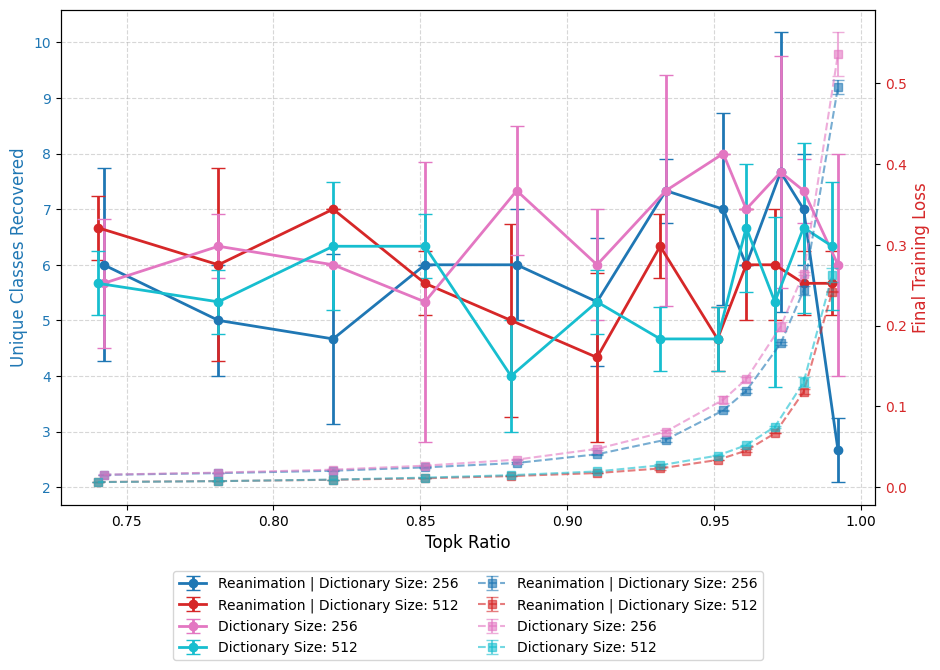

In [226]:
seed_configs = [
        {
            'seed_name': 'seed1',
            'pkl_path': '../logs/mnist_activation/Seed1/topk_sae/regression_results.pkl',
            'additional_log_paths': [
                "../logs/mnist_activation/Seed1/topk_sae/top_k_sae_results_reanim.pt",
                "../logs/mnist_activation/Seed1/topk_sae/top_k_sae_results.pt"
            ]
        },
        {
            'seed_name': 'seed2',
            'pkl_path': '../logs/mnist_activation/Seed2/topk_sae/regression_results.pkl',
            'additional_log_paths': [
                "../logs/mnist_activation/Seed2/topk_sae/top_k_sae_results_reanim.pt",
                "../logs/mnist_activation/Seed2/topk_sae/top_k_sae_results.pt"
            ]
        },
        {
            'seed_name': 'seed3',
            'pkl_path': '../logs/mnist_activation/Seed3/topk_sae/regression_results.pkl',
            'additional_log_paths': [
                "../logs/mnist_activation/Seed3/topk_sae/top_k_sae_results_reanim.pt",
                "../logs/mnist_activation/Seed3/topk_sae/top_k_sae_results.pt"
            ]
        }
    ]
    
df, digit_stats, loss_stats = plot_digit_recovery_multiseed(
    seed_configs=seed_configs,
    out_dir="MnistTopk",
    save=True,
    formats=["pdf", "png"], 
    sae_type='topk'
)

In [147]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
from collections import defaultdict

def parse_sae_name(sae_name, sae_prefix='vanilla'):
    """
    Parse SAE name to extract configuration parameters.

    Args:
        sae_name (str): SAE name string.
        sae_prefix (str): Expected SAE prefix in the name ('vanilla', 'topk', etc.).

    Returns:
        tuple: (has_reanim: bool, dict_size: int or None, penalty: int or None)
    """
    name = sae_name.replace('_best_loss', '')
    has_reanim = name.startswith('reanim_')
    if has_reanim:
        name = name[7:]  # remove reanim_ prefix

    parts = name.split('_')
    if len(parts) >= 4 and parts[0] == sae_prefix and parts[1] == 'sae':
        try:
            dict_size = int(parts[2])
            penalty = int(parts[3])
            return has_reanim, dict_size, penalty
        except ValueError:
            pass


def aggregate_stable_rank_results(all_runs_results, sae_prefix='vanilla', use_frobenius=True, threshold=0.01):
    """
    Aggregate stable rank results from multiple runs.
    
    Args:
        all_runs_results (list[dict]): List of stable rank results dicts (one per run)
        sae_prefix (str): SAE name prefix
        use_frobenius (bool): Whether to use frobenius-based stable rank
        threshold (float): Threshold value if not using frobenius
    
    Returns:
        dict: Aggregated structure -> { (has_reanim, dict_size): { penalty: { enc: [..], dec: [..] } } }
    """
    aggregated = defaultdict(lambda: defaultdict(lambda: {'enc': [], 'dec': []}))
    
    for run_results in all_runs_results:
        for sae_name, sae_results in run_results.items():
            has_reanim, dict_size, penalty = parse_sae_name(sae_name, sae_prefix)
            if dict_size is None or penalty is None:
                continue
            
            if use_frobenius:
                enc_data = sae_results.get('encoder_analysis', {}).get('frobenius', {})
                dec_data = sae_results.get('decoder_analysis', {}).get('frobenius', {})
            else:
                threshold_key = f'threshold_{threshold}'
                enc_data = sae_results.get('encoder_analysis', {}).get(threshold_key, {})
                dec_data = sae_results.get('decoder_analysis', {}).get(threshold_key, {})
            
            enc_stable = enc_data.get('stable_rank')
            dec_stable = dec_data.get('stable_rank')

            if enc_stable is not None and dec_stable is not None:
                aggregated[(has_reanim, dict_size)][penalty]['enc'].append(enc_stable)
                aggregated[(has_reanim, dict_size)][penalty]['dec'].append(dec_stable)
    
    return aggregated


def plot_aggregated_stable_rank(aggregated_results, figsize=(7, 4)):
    """
    Plot aggregated encoder and decoder stable ranks (mean ± std).
    
    Args:
        aggregated_results: Output from aggregate_stable_rank_results
        figsize: Figure size for each plot
    """
    colors = plt.cm.tab10(np.linspace(0, 1, len(aggregated_results)))
    
    # --- Encoder Plot ---
    fig_enc, ax_enc = plt.subplots(figsize=figsize)
    fig_dec, ax_dec = plt.subplots(figsize=figsize)
    
    for i, ((has_reanim, dict_size), penalty_data) in enumerate(aggregated_results.items()):
        penalties = sorted(penalty_data.keys())
        enc_means = [np.mean(penalty_data[p]['enc']) for p in penalties]
        enc_stds = [np.std(penalty_data[p]['enc']) for p in penalties]
        dec_means = [np.mean(penalty_data[p]['dec']) for p in penalties]
        dec_stds = [np.std(penalty_data[p]['dec']) for p in penalties]

        label = f"{'Reanim' if has_reanim else 'Vanilla'} SAE {dict_size}"
        color = colors[i]
        
        ax_enc.errorbar(penalties, enc_means, yerr=enc_stds, fmt='-o', label=label, color=color, capsize=4)
        ax_dec.errorbar(penalties, dec_means, yerr=dec_stds, fmt='-s', label=label, color=color, capsize=4)
    
    # --- Format encoder plot ---
    for ax, title in zip([ax_enc, ax_dec], ['Encoder Stable Rank', 'Decoder Stable Rank']):
        ax.set_title(title, fontweight='bold')
        ax.set_xlabel("Penalty")
        ax.set_ylabel("Stable Rank")
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))

    plt.tight_layout()
    return fig_enc, fig_dec


In [219]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
from collections import defaultdict

def format_variant_label(raw_label, target='Encoder'):
    """
    Format variant labels to show:
    - Reanimation if applicable
    - Dictionary Size
    - Encoder/Decoder
    """
    parts = raw_label.split('_')
    is_reanim = parts[0].lower() == "reanim"
    dict_size = parts[-1] if parts[-1].isdigit() else "?"

    label_parts = []
    if is_reanim:
        label_parts.append("Reanimation")
    label_parts.append(f"Dictionary Size: {dict_size}")
    label_parts.append(target)  # 'Encoder' or 'Decoder'

    return " | ".join(label_parts)


def plot_aggregated_stable_rank_dual_axis(
    aggregated_results,
    sae_type="vanilla",
    figsize=(8, 6),
    out_dir="figures",
    save=False,
    formats=("pdf", "png")
):
    import pandas as pd

    # Prepare L1 penalty mapping
    l1_pen = [round(val, 6) for val in np.logspace(-5, 1, num=30)]

    # Extract all data into DataFrame
    rows = []
    for (has_reanim, dict_size), penalty_data in aggregated_results.items():
        for penalty, values in penalty_data.items():
            enc_mean = np.mean(values['enc'])
            enc_std = np.std(values['enc'])
            dec_mean = np.mean(values['dec'])
            dec_std = np.std(values['dec'])

            variant = f"{'reanim' if has_reanim else 'vanilla'}_{dict_size}"
            rows.append({
                'variant': variant,
                'dict_size': dict_size,
                'penalty': penalty,
                'enc_mean': enc_mean,
                'enc_std': enc_std,
                'dec_mean': dec_mean,
                'dec_std': dec_std
            })

    df = pd.DataFrame(rows)

    # Compute x-axis
    if sae_type == 'topk':
        df['x_axis'] = 1 - (df['penalty'] / df['dict_size'])
        x_label = "Topk Ratio"
    else:
        df['penalty'] = df['penalty'].apply(lambda x: l1_pen[int(x)] if int(x) < len(l1_pen) else np.nan)
        df = df.dropna(subset=['penalty'])
        df['x_axis'] = df['penalty']
        x_label = "L1 Penalty"

    # --- Plotting ---
    colors = plt.cm.tab10(np.linspace(0, 1, df['variant'].nunique()))
    fig, ax_enc = plt.subplots(figsize=figsize)
    ax_dec = ax_enc.twinx()

    for i, variant in enumerate(sorted(df['variant'].unique())):
        sub = df[df['variant'] == variant].sort_values('x_axis')

        # Encoder
        ax_enc.errorbar(
            sub['x_axis'], sub['enc_mean'], yerr=sub['enc_std'],
            fmt='-o', color=colors[i], capsize=4,
            label=format_variant_label(variant, target='Encoder')
        )

        # Decoder
        ax_dec.errorbar(
            sub['x_axis'], sub['dec_mean'], yerr=sub['dec_std'],
            fmt='--s', color=colors[i], capsize=4,
            label=format_variant_label(variant, target='Decoder')
        )

    # --- Axes formatting ---
    ax_enc.set_xlabel(x_label, fontsize=13)
    ax_enc.set_ylabel("Encoder Stable Rank", color='tab:blue', fontsize=12)
    ax_dec.set_ylabel("Decoder Stable Rank", color='tab:red', fontsize=12)
    ax_enc.tick_params(axis='y', labelcolor='tab:blue')
    ax_dec.tick_params(axis='y', labelcolor='tab:red')

    if sae_type != 'topk':
        ax_enc.set_xscale('log')
        ax_dec.set_xscale('log')

    ax_enc.grid(True, linestyle='--', alpha=0.4)

    # --- Legend below plot ---
    # --- Legend in two columns: Encoder left, Decoder right ---
    lines_enc, labels_enc = ax_enc.get_legend_handles_labels()
    lines_dec, labels_dec = ax_dec.get_legend_handles_labels()
    
    # Concatenate for two-column legend: left=Encoder, right=Decoder
    handles = lines_enc + lines_dec
    labels = labels_enc + labels_dec
    
    ax_enc.legend(
        handles,
        labels,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.12),
        ncol=2,       # two columns
        frameon=True,
        fontsize=10,
        columnspacing=1.5
    )

    fig.tight_layout(rect=[0, 0.05, 1, 1])
    fig.subplots_adjust(bottom=0.18)  # extra bottom margin for long legend
    fig.align_ylabels([ax_enc, ax_dec])

    # Save
    if save:
        os.makedirs(out_dir, exist_ok=True)
        for fmt in formats:
            out_path = os.path.join(out_dir, f"stable_rank_dual_axis_{sae_type}.{fmt}")
            fig.savefig(out_path, format=fmt, bbox_inches='tight')
            print(f"Saved plot to {out_path}")

    plt.show()
    return df


Saved plot to CifarVanilla/stable_rank_dual_axis_vanilla.pdf
Saved plot to CifarVanilla/stable_rank_dual_axis_vanilla.png


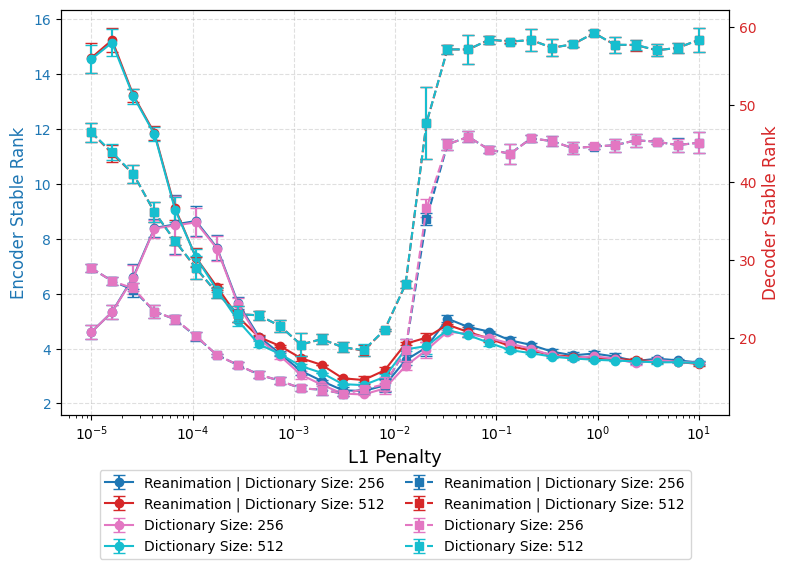

In [202]:

with open('../logs/cifar10expt5/Seed1/vanilla_sae/stable_rank_results.pkl', 'rb') as f1, \
     open('../logs/cifar10expt5/Seed2/vanilla_sae/stable_rank_results.pkl', 'rb') as f2, \
     open('../logs/cifar10expt5/Seed3/vanilla_sae/stable_rank_results.pkl', 'rb') as f3:
    run1, run2, run3 = pickle.load(f1), pickle.load(f2), pickle.load(f3)

aggregated = aggregate_stable_rank_results([run1, run2, run3], sae_prefix='vanilla')
fig = plot_aggregated_stable_rank_dual_axis(aggregated, save=True, out_dir='CifarVanilla')
plt.show()

Saved plot to MnistVanilla/stable_rank_dual_axis_vanilla.pdf
Saved plot to MnistVanilla/stable_rank_dual_axis_vanilla.png


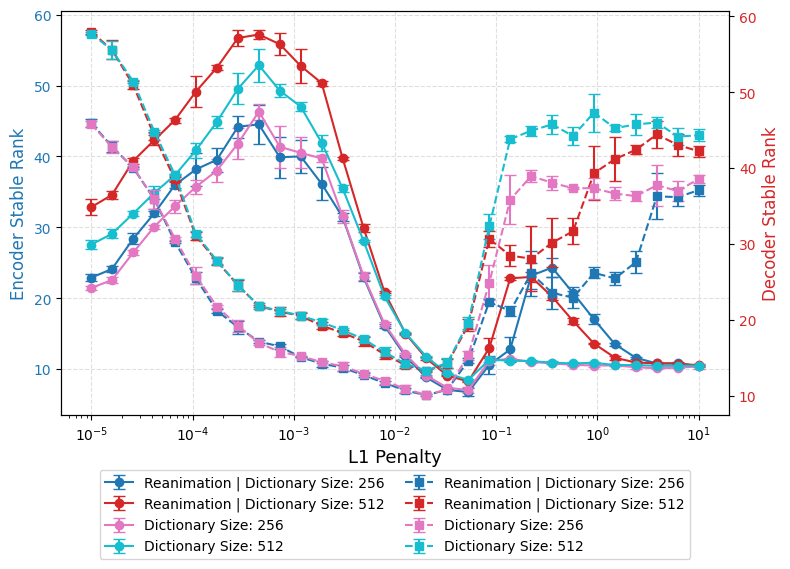

In [203]:
with open('../logs/mnist_activation/Seed1/vanilla_sae/stable_rank_results.pkl', 'rb') as f1, \
     open('../logs/mnist_activation/Seed2/vanilla_sae/stable_rank_results.pkl', 'rb') as f2, \
     open('../logs/mnist_activation/Seed3/vanilla_sae/stable_rank_results.pkl', 'rb') as f3:
    run1, run2, run3 = pickle.load(f1), pickle.load(f2), pickle.load(f3)

aggregated = aggregate_stable_rank_results([run1, run2, run3], sae_prefix='vanilla')
fig = plot_aggregated_stable_rank_dual_axis(aggregated, save=True, out_dir='MnistVanilla')
plt.show()

Saved plot to MnistTopk/stable_rank_dual_axis_topk.pdf
Saved plot to MnistTopk/stable_rank_dual_axis_topk.png


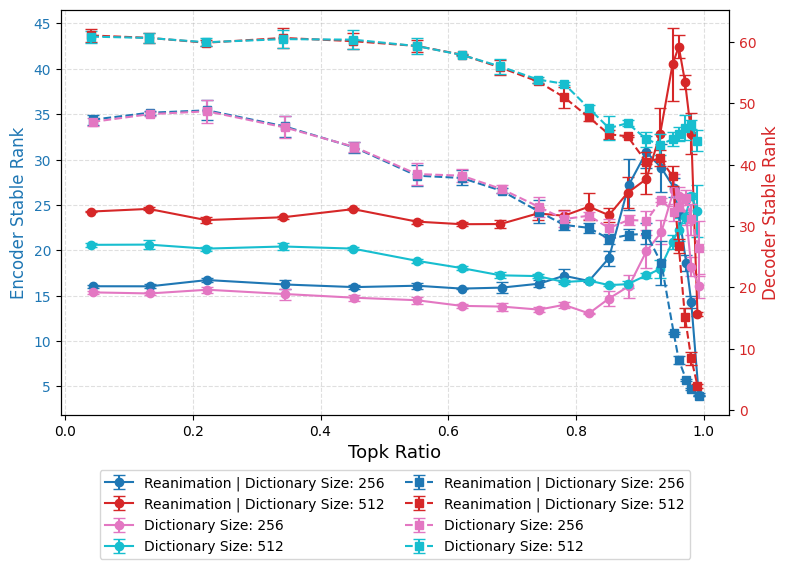

In [205]:
with open('../logs/mnist_activation/Seed1/topk_sae/stable_rank_results.pkl', 'rb') as f1, \
     open('../logs/mnist_activation/Seed2/topk_sae/stable_rank_results.pkl', 'rb') as f2, \
     open('../logs/mnist_activation/Seed3/topk_sae/stable_rank_results.pkl', 'rb') as f3:
    run1, run2, run3 = pickle.load(f1), pickle.load(f2), pickle.load(f3)

aggregated = aggregate_stable_rank_results([run1, run2, run3], sae_prefix='topk')
fig = plot_aggregated_stable_rank_dual_axis(aggregated, sae_type="topk", save=True, out_dir='MnistTopk')
plt.show()

Saved plot to CifarTopk/stable_rank_dual_axis_topk.pdf
Saved plot to CifarTopk/stable_rank_dual_axis_topk.png


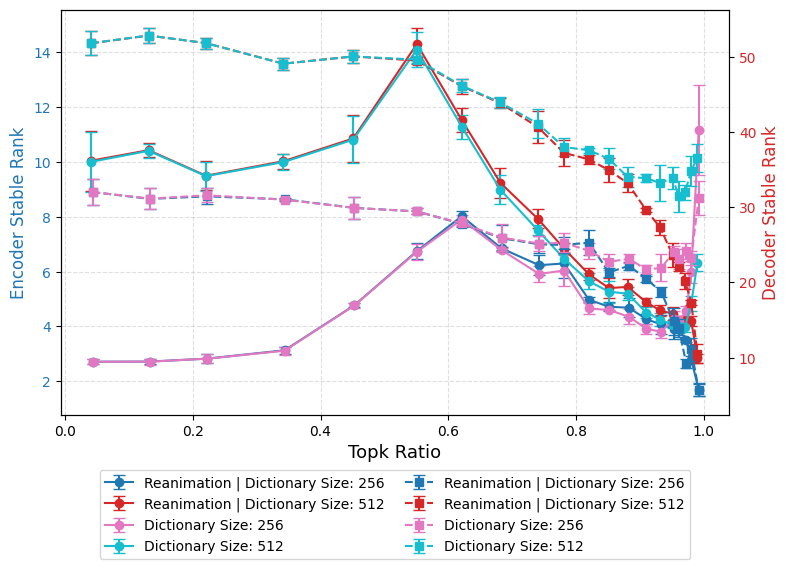

In [206]:
with open('../logs/cifar10expt5/Seed1/topk_sae/stable_rank_results.pkl', 'rb') as f1, \
     open('../logs/cifar10expt5/Seed2/topk_sae/stable_rank_results.pkl', 'rb') as f2, \
     open('../logs/cifar10expt5/Seed3/topk_sae/stable_rank_results.pkl', 'rb') as f3:
    run1, run2, run3 = pickle.load(f1), pickle.load(f2), pickle.load(f3)

aggregated = aggregate_stable_rank_results([run1, run2, run3], sae_prefix='topk')
fig = plot_aggregated_stable_rank_dual_axis(aggregated, sae_type="topk", save=True, out_dir='CifarTopk')
plt.show()

In [3]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from collections import defaultdict
import matplotlib.ticker as mticker


def format_variant_label(variant):
    """Format variant names to show Reanimation status and Dictionary Size."""
    parts = variant.split('_')
    is_reanim = parts[0].lower() == "reanim"
    dict_size = parts[-1] if parts[-1].isdigit() else "?"
    
    label_parts = []
    if is_reanim:
        label_parts.append("Reanimation")
    label_parts.append(f"Dict Size: {dict_size}")
    
    return " | ".join(label_parts)


def parse_sae_name(sae_name, sae_prefix='vanilla'):
    """Parse SAE name to extract configuration parameters."""
    name = sae_name.replace('_best_loss', '')
    has_reanim = name.startswith('reanim_')
    if has_reanim:
        name = name[7:]

    parts = name.split('_')
    if len(parts) >= 4 and parts[0] == sae_prefix and parts[1] == 'sae':
        try:
            dict_size = int(parts[2])
            penalty = int(parts[3])
            return has_reanim, dict_size, penalty
        except ValueError:
            pass
    return None, None, None


def aggregate_stable_rank_results(all_runs_results, sae_prefix='vanilla', use_frobenius=True, threshold=0.01):
    """Aggregate stable rank results from multiple runs."""
    aggregated = defaultdict(lambda: defaultdict(lambda: {'enc': [], 'dec': []}))
    
    for run_results in all_runs_results:
        for sae_name, sae_results in run_results.items():
            has_reanim, dict_size, penalty = parse_sae_name(sae_name, sae_prefix)
            if dict_size is None or penalty is None:
                continue
            
            if use_frobenius:
                enc_data = sae_results.get('encoder_analysis', {}).get('frobenius', {})
                dec_data = sae_results.get('decoder_analysis', {}).get('frobenius', {})
            else:
                threshold_key = f'threshold_{threshold}'
                enc_data = sae_results.get('encoder_analysis', {}).get(threshold_key, {})
                dec_data = sae_results.get('decoder_analysis', {}).get(threshold_key, {})
            
            enc_stable = enc_data.get('stable_rank')
            dec_stable = dec_data.get('stable_rank')

            if enc_stable is not None and dec_stable is not None:
                aggregated[(has_reanim, dict_size)][penalty]['enc'].append(enc_stable)
                aggregated[(has_reanim, dict_size)][penalty]['dec'].append(dec_stable)
    
    return aggregated


def plot_combined_sae_metrics_single(
    seed_configs,
    stable_rank_results=None,
    sae_type='vanilla',
    sae_prefix='vanilla',
    out_dir="figures",
    save=True,
    formats=("pdf", "png"),
    figsize=(12, 8)
):
    """
    Single plot showing all metrics with multiple y-axes:
    - Left y-axis: Linear Probe Accuracy (Unique Classes Recovered)
    - Right y-axis 1: Training Loss
    - Right y-axis 2: Encoder Stable Rank
    - Right y-axis 3: Decoder Stable Rank
    
    Args:
        seed_configs: List of dicts with pkl_path, log_path, etc. for linear probe data
        stable_rank_results: List of stable rank results dicts (one per run)
        sae_type: 'vanilla' or 'topk'
        sae_prefix: Prefix for SAE names
        out_dir: Output directory for saved figures
        save: Whether to save the figure
        formats: Tuple of formats to save (e.g., ('pdf', 'png'))
        figsize: Figure size
    """
    
    # ==================== Load Linear Probe Data ====================
    all_data = []
    for seed_config in seed_configs:
        pkl_path = seed_config['pkl_path']
        log_path = seed_config.get('log_path', None)
        additional_log_paths = seed_config.get('additional_log_paths', None)
        seed_name = seed_config.get('seed_name', f'seed_{len(all_data) + 1}')

        with open(pkl_path, "rb") as f:
            all_results = pickle.load(f)

        training_logs = {}
        if log_path:
            training_logs.update(torch.load(log_path))
        if additional_log_paths:
            for add_log_path in additional_log_paths:
                training_logs.update(torch.load(add_log_path))

        for sae_name, results in all_results.items():
            if "auc_matrix" not in results or "per_neuron_df" not in results:
                continue

            sae_name_clean = sae_name.replace("_best_loss", "")
            try:
                penalty = float(sae_name_clean.split("_")[-1])
                variant = "_".join(sae_name_clean.split("_")[:-1])
            except ValueError:
                continue

            auc_matrix = results["auc_matrix"]
            neuron_df = results["per_neuron_df"]

            count_per_neuron = (auc_matrix > 0.95).sum(axis=1)
            pure_neurons = count_per_neuron[count_per_neuron == 1].index
            digits_represented = neuron_df.loc[pure_neurons, "best_digit"]
            num_digits = digits_represented.nunique()

            final_loss = None
            if training_logs and sae_name_clean in training_logs:
                final_loss = training_logs[sae_name_clean]['avg_loss'][-1]

            all_data.append({
                'seed': seed_name,
                'variant': variant,
                'penalty': penalty,
                'num_digits': num_digits,
                'final_loss': final_loss
            })

    df_probe = pd.DataFrame(all_data)

    # ==================== Process Linear Probe Data ====================
    l1_pen = [round(val, 6) for val in np.logspace(-5, 1, num=30)]
    
    if sae_type == 'topk':
        df_probe['dictionary_size'] = df_probe.variant.apply(lambda x: float(x.split('_')[-1]))
        df_probe['x_axis'] = 1 - (df_probe['penalty'] / df_probe['dictionary_size'])
        x_label = "Topk Ratio"
    else:
        df_probe['penalty'] = df_probe['penalty'].apply(lambda x: l1_pen[int(x)])
        df_probe['x_axis'] = df_probe['penalty']
        x_label = "L1 Penalty"

    # Compute statistics
    group_cols = ['variant', 'x_axis']
    digit_stats = df_probe.groupby(group_cols)['num_digits'].agg(['mean', 'std']).reset_index()
    digit_stats['std'] = digit_stats['std'].fillna(0)

    loss_stats = df_probe[df_probe['final_loss'].notna()].groupby(group_cols)['final_loss'].agg(['mean', 'std']).reset_index()
    loss_stats['std'] = loss_stats['std'].fillna(0)

    # Filter to focus range - REMOVED FILTERING FOR PROBE ACCURACY
    # Keep all data without clipping

    # ==================== Process Stable Rank Data ====================
    df_stable = None
    if stable_rank_results:
        aggregated = aggregate_stable_rank_results(stable_rank_results, sae_prefix)
        
        rows = []
        for (has_reanim, dict_size), penalty_data in aggregated.items():
            for penalty, values in penalty_data.items():
                variant = f"{'reanim' if has_reanim else 'vanilla'}_{dict_size}"
                rows.append({
                    'variant': variant,
                    'dict_size': dict_size,
                    'penalty': penalty,
                    'enc_mean': np.mean(values['enc']),
                    'enc_std': np.std(values['enc']),
                    'dec_mean': np.mean(values['dec']),
                    'dec_std': np.std(values['dec'])
                })

        df_stable = pd.DataFrame(rows)
        
        if sae_type == 'topk':
            df_stable['x_axis'] = 1 - (df_stable['penalty'] / df_stable['dict_size'])
        else:
            df_stable['penalty'] = df_stable['penalty'].apply(lambda x: l1_pen[int(x)] if int(x) < len(l1_pen) else np.nan)
            df_stable = df_stable.dropna(subset=['penalty'])
            df_stable['x_axis'] = df_stable['penalty']

    # ==================== Create Single Plot with Multiple Y-Axes ====================
    fig, ax1 = plt.subplots(figsize=figsize)
    
    # Create additional y-axes
    ax2 = ax1.twinx()  # For loss
    ax3 = ax1.twinx()  # For encoder stable rank
    ax4 = ax1.twinx()  # For decoder stable rank
    
    # Offset the right spines
    ax3.spines['right'].set_position(('outward', 60))
    ax4.spines['right'].set_position(('outward', 120))

    # Get variants and colors
    variants = sorted(digit_stats['variant'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(variants)))
    
    all_lines = []
    all_labels = []

    # ==================== Plot 1: Linear Probe Accuracy (ax1) ====================
    for idx, variant in enumerate(variants):
        variant_data = digit_stats[digit_stats['variant'] == variant].sort_values('x_axis')
        pretty_label = format_variant_label(variant)

        line = ax1.errorbar(
            variant_data['x_axis'],
            variant_data['mean'],
            yerr=variant_data['std'],
            marker="o",
            linewidth=2,
            capsize=4,
            label=f"{pretty_label} (Accuracy)",
            color=colors[idx],
            linestyle='-'
        )
        all_lines.append(line)
        all_labels.append(f"{pretty_label} (Acc)")

    ax1.set_xlabel(x_label, fontsize=13, fontweight='bold')
    ax1.set_ylabel("Unique Classes Recovered", fontsize=12, color='C0', fontweight='bold')
    ax1.tick_params(axis='y', labelcolor='C0')
    ax1.grid(True, linestyle="--", alpha=0.3)
    if sae_type != 'topk':
        ax1.set_xscale('log')

    # ==================== Plot 2: Training Loss (ax2) ====================
    if not loss_stats.empty:
        for idx, variant in enumerate(variants):
            variant_loss_data = loss_stats[loss_stats['variant'] == variant].sort_values('x_axis')
            if not variant_loss_data.empty:
                pretty_label = format_variant_label(variant)
                line = ax2.errorbar(
                    variant_loss_data['x_axis'],
                    variant_loss_data['mean'],
                    yerr=variant_loss_data['std'],
                    marker="s",
                    linewidth=1.5,
                    capsize=3,
                    alpha=0.7,
                    label=f"{pretty_label} (Loss)",
                    color=colors[idx],
                    linestyle='--'
                )
                all_lines.append(line)
                all_labels.append(f"{pretty_label} (Loss)")

        ax2.set_ylabel("Training Loss", fontsize=12, color='C1', fontweight='bold')
        ax2.tick_params(axis='y', labelcolor='C1')
        if sae_type != 'topk':
            ax2.set_xscale('log')

    # ==================== Plot 3: Encoder Stable Rank (ax3) ====================
    if df_stable is not None:
        for idx, variant in enumerate(sorted(df_stable['variant'].unique())):
            sub = df_stable[df_stable['variant'] == variant].sort_values('x_axis')
            pretty_label = format_variant_label(variant)

            line = ax3.errorbar(
                sub['x_axis'], 
                sub['enc_mean'], 
                yerr=sub['enc_std'],
                marker="^",
                linewidth=1.5,
                capsize=3,
                alpha=0.7,
                label=f"{pretty_label} (Enc SR)",
                color=colors[idx],
                linestyle='-.'
            )
            all_lines.append(line)
            all_labels.append(f"{pretty_label} (Enc)")

        ax3.set_ylabel("Encoder Stable Rank", fontsize=12, color='C2', fontweight='bold')
        ax3.tick_params(axis='y', labelcolor='C2')
        if sae_type != 'topk':
            ax3.set_xscale('log')

    # ==================== Plot 4: Decoder Stable Rank (ax4) ====================
    if df_stable is not None:
        for idx, variant in enumerate(sorted(df_stable['variant'].unique())):
            sub = df_stable[df_stable['variant'] == variant].sort_values('x_axis')
            pretty_label = format_variant_label(variant)

            line = ax4.errorbar(
                sub['x_axis'], 
                sub['dec_mean'], 
                yerr=sub['dec_std'],
                marker="v",
                linewidth=1.5,
                capsize=3,
                alpha=0.7,
                label=f"{pretty_label} (Dec SR)",
                color=colors[idx],
                linestyle=':'
            )
            all_lines.append(line)
            all_labels.append(f"{pretty_label} (Dec)")

        ax4.set_ylabel("Decoder Stable Rank", fontsize=12, color='C3', fontweight='bold')
        ax4.tick_params(axis='y', labelcolor='C3')
        if sae_type != 'topk':
            ax4.set_xscale('log')

    # ==================== Legend ====================
    fig.legend(
        all_lines,
        all_labels,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.05),
        ncol=min(4, len(all_labels)//4 + 1),
        frameon=True,
        fontsize=9,
        columnspacing=1.2
    )

    plt.title("Combined SAE Metrics Analysis", fontsize=14, fontweight='bold', pad=20)
    fig.tight_layout()
    plt.subplots_adjust(bottom=0.15, right=0.75)

    # ==================== Save ====================
    if save:
        os.makedirs(out_dir, exist_ok=True)
        for fmt in formats:
            out_file = os.path.join(out_dir, f"combined_sae_metrics_single_{sae_type}.{fmt}")
            plt.savefig(out_file, format=fmt, bbox_inches="tight", dpi=300)
            print(f"Saved combined plot to {out_file}")

    plt.show()

    return df_probe, digit_stats, loss_stats, df_stable

/tmp/ipykernel_1244368/1642379215.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_logs.update(torch.load(add_log_path))
/tmp/ipykernel_1244368/1642379215.py:1

Saved combined plot to CifarVanilla/combined_sae_metrics_single_vanilla.pdf
Saved combined plot to CifarVanilla/combined_sae_metrics_single_vanilla.png


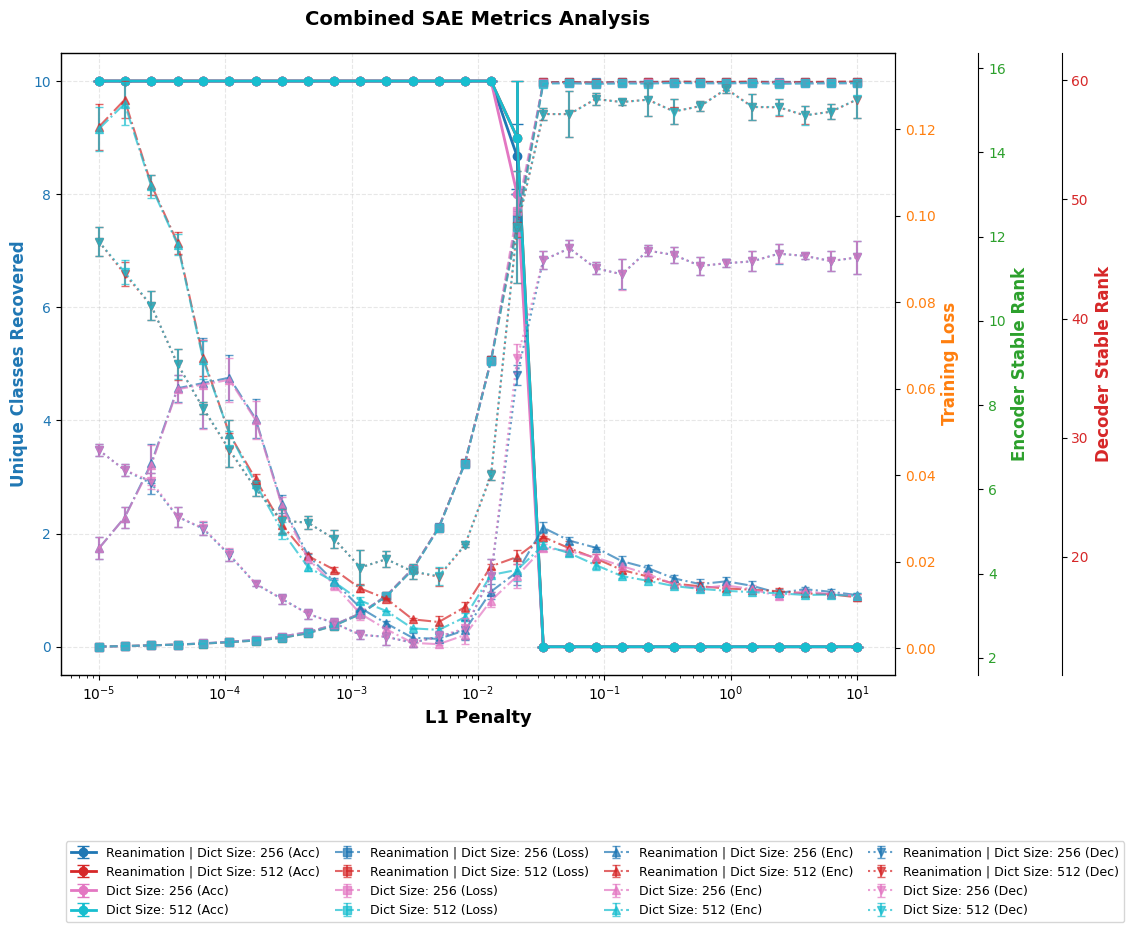

In [4]:
import pickle
import matplotlib.pyplot as plt

# Load stable rank results
with open('../logs/cifar10expt5/Seed1/vanilla_sae/stable_rank_results.pkl', 'rb') as f1, \
     open('../logs/cifar10expt5/Seed2/vanilla_sae/stable_rank_results.pkl', 'rb') as f2, \
     open('../logs/cifar10expt5/Seed3/vanilla_sae/stable_rank_results.pkl', 'rb') as f3:
    run1, run2, run3 = pickle.load(f1), pickle.load(f2), pickle.load(f3)

# Prepare seed configs
seed_configs = [
    {
            'seed_name': 'seed1',
            'pkl_path': '../logs/cifar10expt5/Seed1/vanilla_sae/regression_results.pkl',
            'additional_log_paths': [
                "../logs/cifar10expt5/Seed1/vanilla_sae/vanilla_sae_results_reanim.pt",
                "../logs/cifar10expt5/Seed1/vanilla_sae/vanilla_sae_results.pt"
            ]
        },
        {
            'seed_name': 'seed2',
            'pkl_path': '../logs/cifar10expt5/Seed2/vanilla_sae/regression_results.pkl',
            'additional_log_paths': [
                "../logs/cifar10expt5/Seed2/vanilla_sae/vanilla_sae_results_reanim.pt",
                "../logs/cifar10expt5/Seed2/vanilla_sae/vanilla_sae_results.pt"
            ]
        },
        {
            'seed_name': 'seed3',
            'pkl_path': '../logs/cifar10expt5/Seed3/vanilla_sae/regression_results.pkl',
            'additional_log_paths': [
                "../logs/cifar10expt5/Seed3/vanilla_sae/vanilla_sae_results_reanim.pt",
                "../logs/cifar10expt5/Seed3/vanilla_sae/vanilla_sae_results.pt"
            ]
        }
]

# Run the combined plot
df_probe, digit_stats, loss_stats, df_stable = plot_combined_sae_metrics_single(
    seed_configs=seed_configs,
    stable_rank_results=[run1, run2, run3],
    sae_type='vanilla',
    sae_prefix='vanilla',
    out_dir="CifarVanilla",
    save=True,
    formats=("pdf", "png"),
    figsize=(12, 8)
)

plt.show()

In [5]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from collections import defaultdict


def format_variant_label(variant):
    """Format variant names to show Reanimation status and Dictionary Size."""
    parts = variant.split('_')
    is_reanim = parts[0].lower() == "reanim"
    dict_size = parts[-1] if parts[-1].isdigit() else "?"
    
    label_parts = []
    if is_reanim:
        label_parts.append("Reanimation")
    label_parts.append(f"Dict Size: {dict_size}")
    
    return " | ".join(label_parts)


def parse_sae_name(sae_name, sae_prefix='vanilla'):
    """Parse SAE name to extract configuration parameters."""
    name = sae_name.replace('_best_loss', '')
    has_reanim = name.startswith('reanim_')
    if has_reanim:
        name = name[7:]

    parts = name.split('_')
    if len(parts) >= 4 and parts[0] == sae_prefix and parts[1] == 'sae':
        try:
            dict_size = int(parts[2])
            penalty = int(parts[3])
            return has_reanim, dict_size, penalty
        except ValueError:
            pass
    return None, None, None


def aggregate_stable_rank_results(all_runs_results, sae_prefix='vanilla', use_frobenius=True, threshold=0.01):
    """Aggregate stable rank results from multiple runs."""
    aggregated = defaultdict(lambda: defaultdict(lambda: {'enc': [], 'dec': []}))
    
    for run_results in all_runs_results:
        for sae_name, sae_results in run_results.items():
            has_reanim, dict_size, penalty = parse_sae_name(sae_name, sae_prefix)
            if dict_size is None or penalty is None:
                continue
            
            if use_frobenius:
                enc_data = sae_results.get('encoder_analysis', {}).get('frobenius', {})
                dec_data = sae_results.get('decoder_analysis', {}).get('frobenius', {})
            else:
                threshold_key = f'threshold_{threshold}'
                enc_data = sae_results.get('encoder_analysis', {}).get(threshold_key, {})
                dec_data = sae_results.get('decoder_analysis', {}).get(threshold_key, {})
            
            enc_stable = enc_data.get('stable_rank')
            dec_stable = dec_data.get('stable_rank')

            if enc_stable is not None and dec_stable is not None:
                aggregated[(has_reanim, dict_size)][penalty]['enc'].append(enc_stable)
                aggregated[(has_reanim, dict_size)][penalty]['dec'].append(dec_stable)
    
    return aggregated


def plot_loss_and_stable_rank(
    seed_configs,
    stable_rank_results=None,
    sae_type='vanilla',
    sae_prefix='vanilla',
    out_dir="figures",
    save=True,
    formats=("pdf", "png"),
    figsize=(12, 8)
):
    """
    Single plot showing loss and stable rank metrics with multiple y-axes:
    - Left y-axis: Training Loss
    - Right y-axis 1: Encoder Stable Rank
    - Right y-axis 2: Decoder Stable Rank
    
    Args:
        seed_configs: List of dicts with pkl_path, log_path, etc. for loss data
        stable_rank_results: List of stable rank results dicts (one per run)
        sae_type: 'vanilla' or 'topk'
        sae_prefix: Prefix for SAE names
        out_dir: Output directory for saved figures
        save: Whether to save the figure
        formats: Tuple of formats to save (e.g., ('pdf', 'png'))
        figsize: Figure size
    """
    
    # ==================== Load Loss Data ====================
    all_data = []
    for seed_config in seed_configs:
        pkl_path = seed_config['pkl_path']
        log_path = seed_config.get('log_path', None)
        additional_log_paths = seed_config.get('additional_log_paths', None)
        seed_name = seed_config.get('seed_name', f'seed_{len(all_data) + 1}')

        with open(pkl_path, "rb") as f:
            all_results = pickle.load(f)

        training_logs = {}
        if log_path:
            training_logs.update(torch.load(log_path))
        if additional_log_paths:
            for add_log_path in additional_log_paths:
                training_logs.update(torch.load(add_log_path))

        for sae_name, results in all_results.items():
            sae_name_clean = sae_name.replace("_best_loss", "")
            try:
                penalty = float(sae_name_clean.split("_")[-1])
                variant = "_".join(sae_name_clean.split("_")[:-1])
            except ValueError:
                continue

            final_loss = None
            if training_logs and sae_name_clean in training_logs:
                final_loss = training_logs[sae_name_clean]['avg_loss'][-1]

            if final_loss is not None:
                all_data.append({
                    'seed': seed_name,
                    'variant': variant,
                    'penalty': penalty,
                    'final_loss': final_loss
                })

    df_loss = pd.DataFrame(all_data)

    # ==================== Process Loss Data ====================
    l1_pen = [round(val, 6) for val in np.logspace(-5, 1, num=30)]
    
    if sae_type == 'topk':
        df_loss['dictionary_size'] = df_loss.variant.apply(lambda x: float(x.split('_')[-1]))
        df_loss['x_axis'] = 1 - (df_loss['penalty'] / df_loss['dictionary_size'])
        x_label = "Topk Ratio"
    else:
        df_loss['penalty'] = df_loss['penalty'].apply(lambda x: l1_pen[int(x)])
        df_loss['x_axis'] = df_loss['penalty']
        x_label = "L1 Penalty"

    # Compute statistics
    group_cols = ['variant', 'x_axis']
    loss_stats = df_loss.groupby(group_cols)['final_loss'].agg(['mean', 'std']).reset_index()
    loss_stats['std'] = loss_stats['std'].fillna(0)

    # ==================== Process Stable Rank Data ====================
    df_stable = None
    if stable_rank_results:
        aggregated = aggregate_stable_rank_results(stable_rank_results, sae_prefix)
        
        rows = []
        for (has_reanim, dict_size), penalty_data in aggregated.items():
            for penalty, values in penalty_data.items():
                variant = f"{'reanim' if has_reanim else 'vanilla'}_{dict_size}"
                rows.append({
                    'variant': variant,
                    'dict_size': dict_size,
                    'penalty': penalty,
                    'enc_mean': np.mean(values['enc']),
                    'enc_std': np.std(values['enc']),
                    'dec_mean': np.mean(values['dec']),
                    'dec_std': np.std(values['dec'])
                })

        df_stable = pd.DataFrame(rows)
        
        if sae_type == 'topk':
            df_stable['x_axis'] = 1 - (df_stable['penalty'] / df_stable['dict_size'])
        else:
            df_stable['penalty'] = df_stable['penalty'].apply(lambda x: l1_pen[int(x)] if int(x) < len(l1_pen) else np.nan)
            df_stable = df_stable.dropna(subset=['penalty'])
            df_stable['x_axis'] = df_stable['penalty']

    # ==================== Create Single Plot with Multiple Y-Axes ====================
    fig, ax1 = plt.subplots(figsize=figsize)
    
    # Create additional y-axes
    ax2 = ax1.twinx()  # For encoder stable rank
    ax3 = ax1.twinx()  # For decoder stable rank
    
    # Offset the right spines
    ax3.spines['right'].set_position(('outward', 60))

    # Get variants and colors
    variants = sorted(loss_stats['variant'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(variants)))
    
    all_lines = []
    all_labels = []

    # ==================== Plot 1: Training Loss (ax1) ====================
    for idx, variant in enumerate(variants):
        variant_loss_data = loss_stats[loss_stats['variant'] == variant].sort_values('x_axis')
        if not variant_loss_data.empty:
            pretty_label = format_variant_label(variant)
            line = ax1.errorbar(
                variant_loss_data['x_axis'],
                variant_loss_data['mean'],
                yerr=variant_loss_data['std'],
                marker="o",
                linewidth=2,
                capsize=4,
                label=f"{pretty_label} (Loss)",
                color=colors[idx],
                linestyle='-'
            )
            all_lines.append(line)
            all_labels.append(f"{pretty_label} (Loss)")

    ax1.set_xlabel(x_label, fontsize=13, fontweight='bold')
    ax1.set_ylabel("Training Loss", fontsize=12, color='C0', fontweight='bold')
    ax1.tick_params(axis='y', labelcolor='C0')
    ax1.grid(True, linestyle="--", alpha=0.3)
    if sae_type != 'topk':
        ax1.set_xscale('log')

    # ==================== Plot 2: Encoder Stable Rank (ax2) ====================
    if df_stable is not None:
        for idx, variant in enumerate(sorted(df_stable['variant'].unique())):
            sub = df_stable[df_stable['variant'] == variant].sort_values('x_axis')
            pretty_label = format_variant_label(variant)

            line = ax2.errorbar(
                sub['x_axis'], 
                sub['enc_mean'], 
                yerr=sub['enc_std'],
                marker="s",
                linewidth=2,
                capsize=4,
                alpha=0.7,
                label=f"{pretty_label} (Enc SR)",
                color=colors[idx],
                linestyle='--'
            )
            all_lines.append(line)
            all_labels.append(f"{pretty_label} (Enc)")

        ax2.set_ylabel("Encoder Stable Rank", fontsize=12, color='C1', fontweight='bold')
        ax2.tick_params(axis='y', labelcolor='C1')
        if sae_type != 'topk':
            ax2.set_xscale('log')

    # ==================== Plot 3: Decoder Stable Rank (ax3) ====================
    if df_stable is not None:
        for idx, variant in enumerate(sorted(df_stable['variant'].unique())):
            sub = df_stable[df_stable['variant'] == variant].sort_values('x_axis')
            pretty_label = format_variant_label(variant)

            line = ax3.errorbar(
                sub['x_axis'], 
                sub['dec_mean'], 
                yerr=sub['dec_std'],
                marker="^",
                linewidth=2,
                capsize=4,
                alpha=0.7,
                label=f"{pretty_label} (Dec SR)",
                color=colors[idx],
                linestyle='-.'
            )
            all_lines.append(line)
            all_labels.append(f"{pretty_label} (Dec)")

        ax3.set_ylabel("Decoder Stable Rank", fontsize=12, color='C2', fontweight='bold')
        ax3.tick_params(axis='y', labelcolor='C2')
        if sae_type != 'topk':
            ax3.set_xscale('log')

    # ==================== Legend ====================
    fig.legend(
        all_lines,
        all_labels,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.05),
        ncol=min(3, len(all_labels)//3 + 1),
        frameon=True,
        fontsize=9,
        columnspacing=1.2
    )

    plt.title("Loss and Stable Rank Analysis", fontsize=14, fontweight='bold', pad=20)
    fig.tight_layout()
    plt.subplots_adjust(bottom=0.15, right=0.85)

    # ==================== Save ====================
    if save:
        os.makedirs(out_dir, exist_ok=True)
        for fmt in formats:
            out_file = os.path.join(out_dir, f"loss_stable_rank_{sae_type}.{fmt}")
            plt.savefig(out_file, format=fmt, bbox_inches="tight", dpi=300)
            print(f"Saved plot to {out_file}")

    plt.show()

    return df_loss, loss_stats, df_stable

/tmp/ipykernel_1244368/370569347.py:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_logs.update(torch.load(add_log_path))
/tmp/ipykernel_1244368/370569347.py:113

Saved plot to CifarVanilla/loss_stable_rank_vanilla.pdf
Saved plot to CifarVanilla/loss_stable_rank_vanilla.png


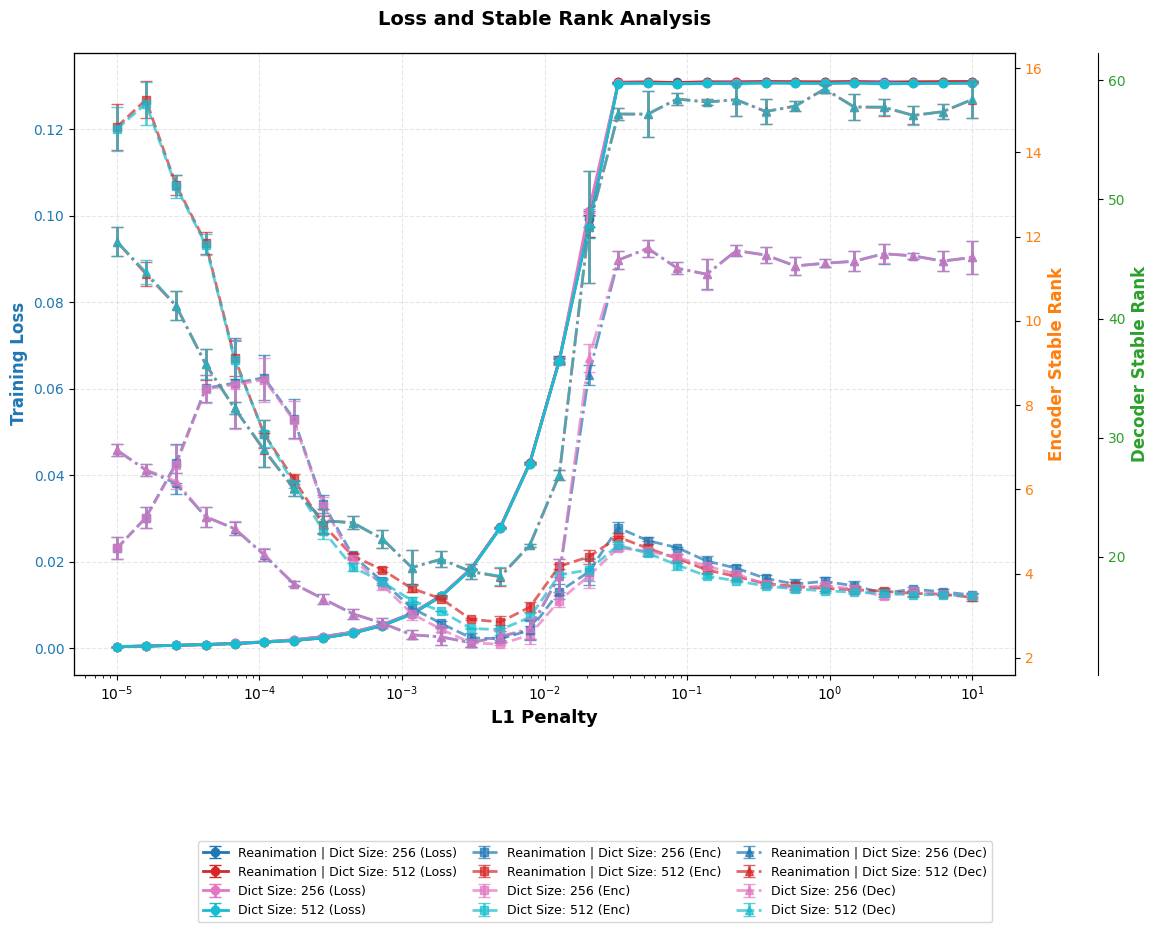

In [6]:
import pickle
import matplotlib.pyplot as plt

# Load stable rank results
with open('../logs/cifar10expt5/Seed1/vanilla_sae/stable_rank_results.pkl', 'rb') as f1, \
     open('../logs/cifar10expt5/Seed2/vanilla_sae/stable_rank_results.pkl', 'rb') as f2, \
     open('../logs/cifar10expt5/Seed3/vanilla_sae/stable_rank_results.pkl', 'rb') as f3:
    run1, run2, run3 = pickle.load(f1), pickle.load(f2), pickle.load(f3)

# Prepare seed configs (same as before)
seed_configs = [
    {
        'seed_name': 'seed1',
        'pkl_path': '../logs/cifar10expt5/Seed1/vanilla_sae/regression_results.pkl',
        'additional_log_paths': [
            "../logs/cifar10expt5/Seed1/vanilla_sae/vanilla_sae_results_reanim.pt",
            "../logs/cifar10expt5/Seed1/vanilla_sae/vanilla_sae_results.pt"
        ]
    },
    {
        'seed_name': 'seed2',
        'pkl_path': '../logs/cifar10expt5/Seed2/vanilla_sae/regression_results.pkl',
        'additional_log_paths': [
            "../logs/cifar10expt5/Seed2/vanilla_sae/vanilla_sae_results_reanim.pt",
            "../logs/cifar10expt5/Seed2/vanilla_sae/vanilla_sae_results.pt"
        ]
    },
    {
        'seed_name': 'seed3',
        'pkl_path': '../logs/cifar10expt5/Seed3/vanilla_sae/regression_results.pkl',
        'additional_log_paths': [
            "../logs/cifar10expt5/Seed3/vanilla_sae/vanilla_sae_results_reanim.pt",
            "../logs/cifar10expt5/Seed3/vanilla_sae/vanilla_sae_results.pt"
        ]
    }
]

# Run the loss + stable rank plot
df_loss, loss_stats, df_stable = plot_loss_and_stable_rank(
    seed_configs=seed_configs,
    stable_rank_results=[run1, run2, run3],
    sae_type='vanilla',
    sae_prefix='vanilla',
    out_dir="CifarVanilla",
    save=True,
    formats=("pdf", "png")
)

plt.show()